In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Imports

In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.2


### Data manipulation

**Task**: Given an image of handwritten digit find the digit

**Data**:
- The data are grayscale 28*28 images of scanned handwritten digits
- We will use a CNN to classify them (no need to flatten as when using an MLP)
- The values of the inputs are in [0, 255] so we normalize them to [0, 1]

In [3]:
batch_size = 128
classes = 10
epochs = 100

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

11490434/11490434 [==============================] - 2s 0us/step


### Plotting results

In [4]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


### Cleaning up

In [5]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


### Model creation

- We will use a Functional Model.
    - It is more flexible than the `Sequential` model but ...
    - We need to be careful with the sizes of the layers.
- The first layer should always be an `Input` layer where we specify the input of the model, e.g., the training data
- The other layers can be whatever we want and for each layer we must:
    - Define the input to the layer, i.e., another layer.
    - Define the number of units which also defines the output size.
        - The output size must be always equal to the number of units of the next layer.


In [6]:
def train_model(
        optimizer,
        epochs=100,
        batch_size=128,
        conv_layers=2,
        conv_activation='relu',
        conv_dropout=False,
        output_activation='softmax',
        callbacks=None,
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs


### Without dropout

In [7]:
# Using Adam
optimizer = Adam()

# 3 Convolutional Layers and Logistic Regression
conv_no_drop_model_adam, conv_no_drop_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    conv_layers=3,
    conv_activation='relu',
    conv_dropout=False,
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
conv_no_drop_eval_adam = conv_no_drop_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=conv_no_drop_model_adam)

Finished training.
------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 8)         0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 7, 7, 16)          0         
                                                                 
 Conv2D-3 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 MaxPool2D-3 (MaxPoolin

### Results without dropout

Train Loss     : 0.00130
Validation Loss: 0.06723
Test Loss      : 0.05386
---
Train Accuracy     : 0.99946
Validation Accuracy: 0.99133
Test Accuracy      : 0.99080



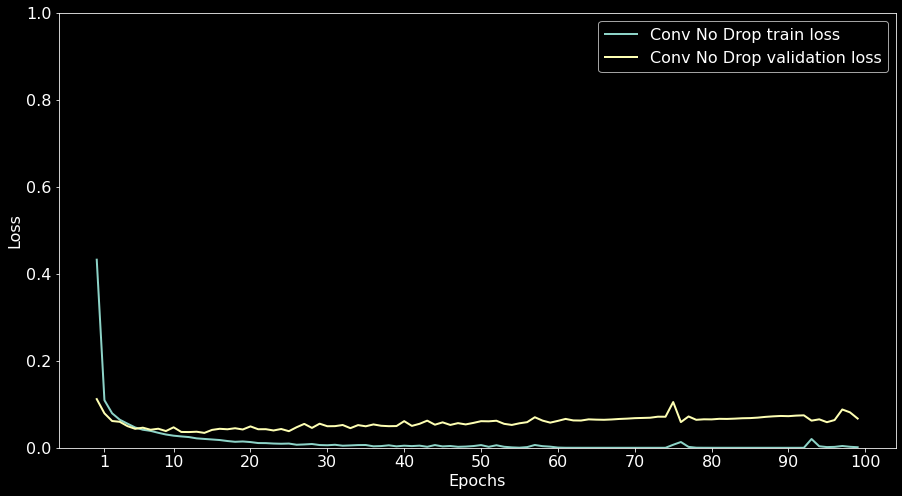

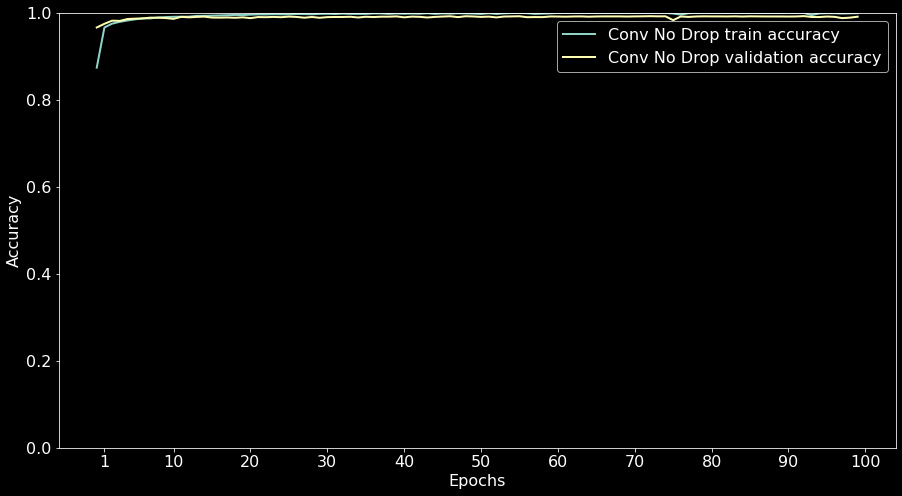

In [8]:
print("Train Loss     : {0:.5f}".format(conv_no_drop_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_no_drop_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_no_drop_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_no_drop_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_no_drop_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_no_drop_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'Conv No Drop': conv_no_drop_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'Conv No Drop': conv_no_drop_hs_adam}, epochs=epochs, metric='accuracy')

### With dropout 0.2

In [9]:
# Using Adam
optimizer = Adam()

# 3 Convolutional Layers and Logistic Regression
conv_drop_eval_model_adam, conv_drop_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    conv_layers=3,
    conv_activation='relu',
    conv_dropout=True,
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
conv_drop_eval_adam = conv_drop_eval_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=conv_drop_eval_model_adam)

Finished training.
------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 8)         0         
                                                                 
 Dropout-1 (Dropout)         (None, 14, 14, 8)         0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 7, 7, 16)          0         
                                                                 
 Dropout-2 (Dropout)   

### No dropout vs. dropout = 0.2

Train Loss     : 0.03617
Validation Loss: 0.02507
Test Loss      : 0.02105
---
Train Accuracy     : 0.98824
Validation Accuracy: 0.99267
Test Accuracy      : 0.99220



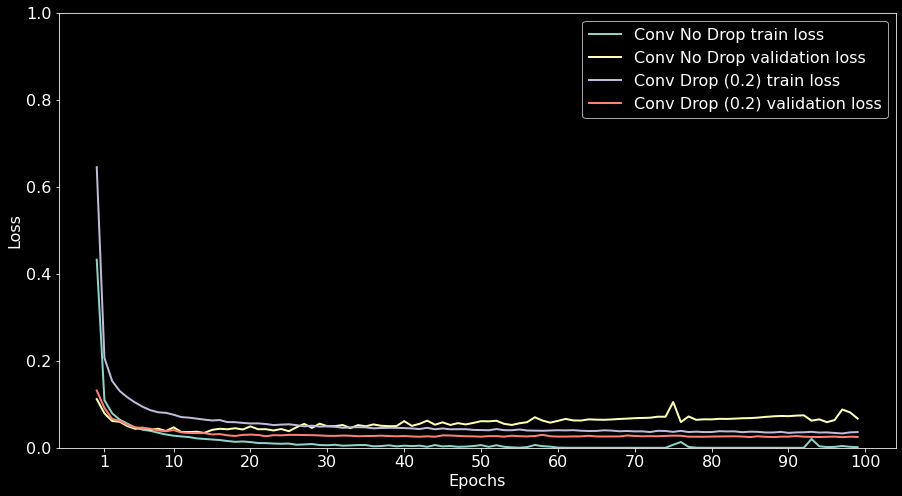

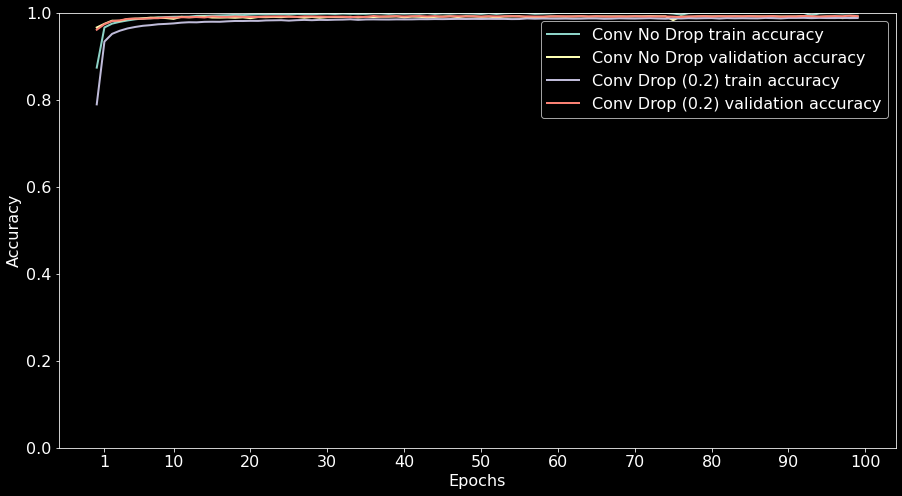

In [10]:
print("Train Loss     : {0:.5f}".format(conv_drop_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_drop_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_drop_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_drop_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_drop_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_drop_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(
    hs={
        'Conv No Drop': conv_no_drop_hs_adam,
        'Conv Drop (0.2)': conv_drop_hs_adam
    },
    epochs=epochs,
    metric='loss'
)
plot_history(
    hs={
        'Conv No Drop': conv_no_drop_hs_adam,
        'Conv Drop (0.2)': conv_drop_hs_adam
    },
    epochs=epochs,
    metric='accuracy'
)

###Using Early Stopping with patience 10

In [11]:
# Using Adam
optimizer = Adam()

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# 3 Convolutional Layers and Logistic Regression
conv_drop_es_10_eval_model_adam, conv_drop_es_10_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    conv_layers=3,
    conv_activation='relu',
    conv_dropout=True,
    output_activation='softmax',
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test data and show all the results.
conv_drop_es_10_eval_adam = conv_drop_es_10_eval_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=conv_drop_es_10_eval_model_adam)

Epoch 1/100
422/422 [==============================] - 3s 5ms/step - loss: 0.6452 - accuracy: 0.7898 - val_loss: 0.1319 - val_accuracy: 0.9617
Epoch 2/100
422/422 [==============================] - 2s 4ms/step - loss: 0.2067 - accuracy: 0.9341 - val_loss: 0.0913 - val_accuracy: 0.9740
Epoch 3/100
422/422 [==============================] - 2s 4ms/step - loss: 0.1542 - accuracy: 0.9516 - val_loss: 0.0664 - val_accuracy: 0.9813
Epoch 4/100
422/422 [==============================] - 2s 6ms/step - loss: 0.1306 - accuracy: 0.9588 - val_loss: 0.0619 - val_accuracy: 0.9823
Epoch 5/100
422/422 [==============================] - 2s 6ms/step - loss: 0.1157 - accuracy: 0.9642 - val_loss: 0.0526 - val_accuracy: 0.9867
Epoch 6/100
422/422 [==============================] - 2s 4ms/step - loss: 0.1039 - accuracy: 0.9676 - val_loss: 0.0468 - val_accuracy: 0.9875
Epoch 7/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0940 - accuracy: 0.9703 - val_loss: 0.0456 - val_accuracy: 0.9863

Train Loss     : 0.04607
Validation Loss: 0.02796
Test Loss      : 0.02323
---
Train Accuracy     : 0.98435
Validation Accuracy: 0.99117
Test Accuracy      : 0.99190



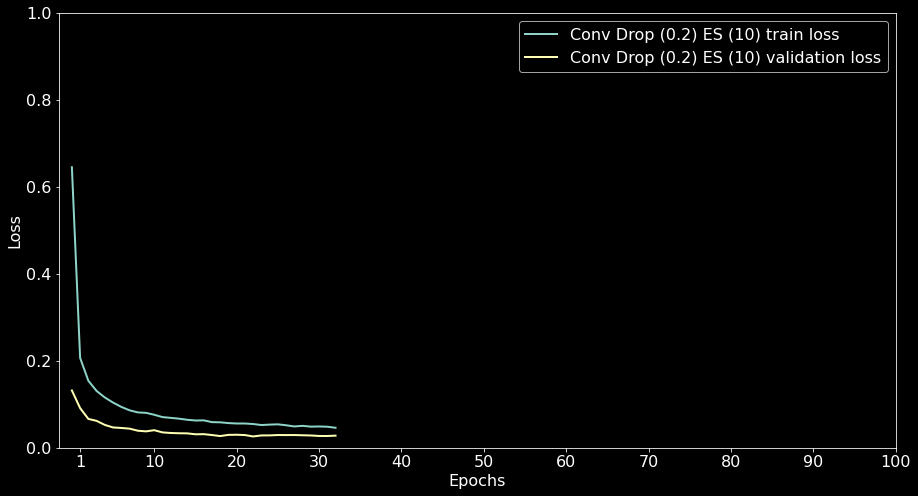

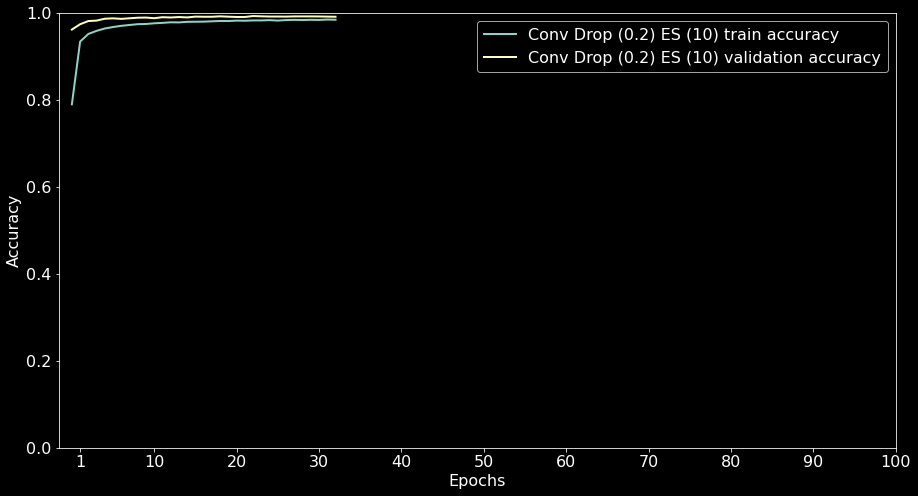

In [13]:
print("Train Loss     : {0:.5f}".format(conv_drop_es_10_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_drop_es_10_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_drop_es_10_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_drop_es_10_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_drop_es_10_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_drop_es_10_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(
    hs={
        'Conv Drop (0.2) ES (10)': conv_drop_es_10_hs_adam
    },
    epochs=epochs,
    metric='loss'
)
plot_history(
    hs={
        'Conv Drop (0.2) ES (10)': conv_drop_es_10_hs_adam
    },
    epochs=epochs,
    metric='accuracy'
)

### Using Early Stopping with patience 20

In [14]:
# Using Adam
optimizer = Adam()

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

# 3 Convolutional Layers and Logistic Regression
conv_drop_es_20_eval_model_adam, conv_drop_es_20_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    conv_layers=3,
    conv_activation='relu',
    conv_dropout=True,
    output_activation='softmax',
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test data and show all the results.
conv_drop_es_20_eval_adam = conv_drop_es_20_eval_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=conv_drop_es_20_eval_model_adam)

Epoch 1/100
422/422 [==============================] - 3s 6ms/step - loss: 0.6454 - accuracy: 0.7898 - val_loss: 0.1319 - val_accuracy: 0.9610
Epoch 2/100
422/422 [==============================] - 2s 5ms/step - loss: 0.2069 - accuracy: 0.9340 - val_loss: 0.0911 - val_accuracy: 0.9743
Epoch 3/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1541 - accuracy: 0.9519 - val_loss: 0.0663 - val_accuracy: 0.9810
Epoch 4/100
422/422 [==============================] - 2s 4ms/step - loss: 0.1305 - accuracy: 0.9590 - val_loss: 0.0613 - val_accuracy: 0.9833
Epoch 5/100
422/422 [==============================] - 2s 6ms/step - loss: 0.1157 - accuracy: 0.9640 - val_loss: 0.0523 - val_accuracy: 0.9860
Epoch 6/100
422/422 [==============================] - 3s 7ms/step - loss: 0.1036 - accuracy: 0.9673 - val_loss: 0.0467 - val_accuracy: 0.9870
Epoch 7/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0939 - accuracy: 0.9706 - val_loss: 0.0454 - val_accuracy: 0.9867

Train Loss     : 0.04089
Validation Loss: 0.02588
Test Loss      : 0.02229
---
Train Accuracy     : 0.98654
Validation Accuracy: 0.99250
Test Accuracy      : 0.99170



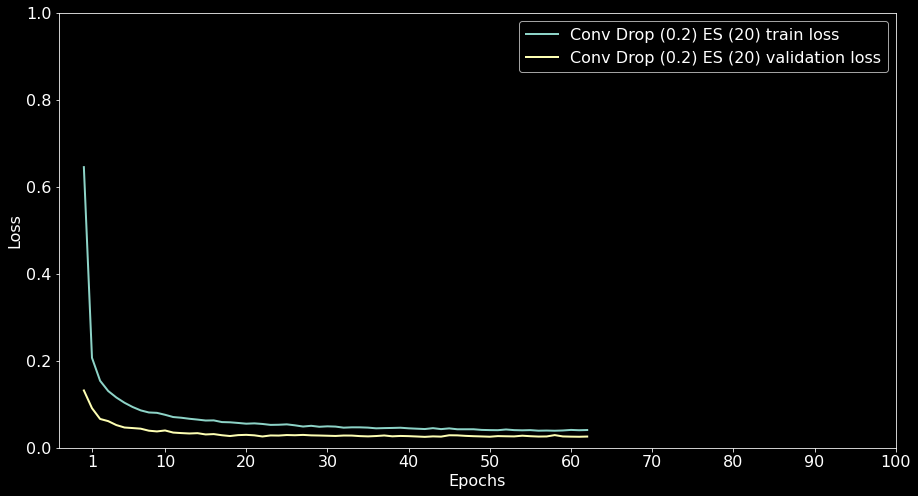

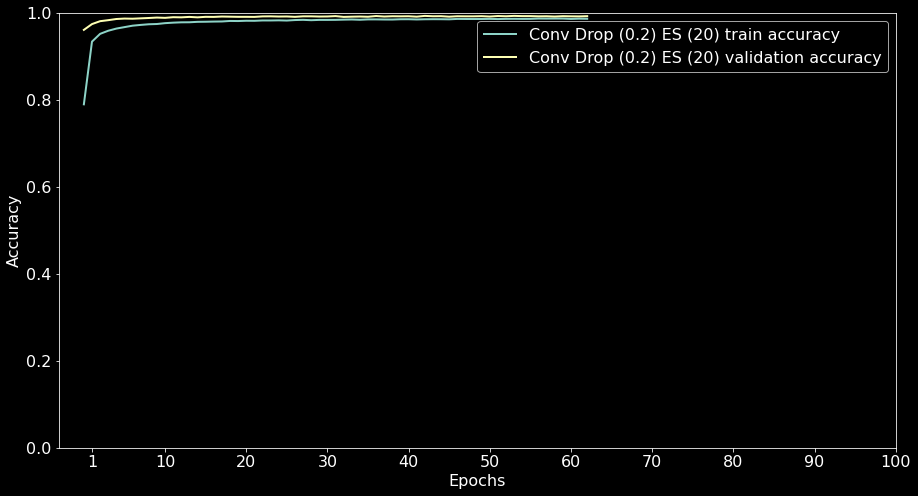

In [15]:
print("Train Loss     : {0:.5f}".format(conv_drop_es_20_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_drop_es_20_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_drop_es_20_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_drop_es_20_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_drop_es_20_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_drop_es_20_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(
    hs={
        'Conv Drop (0.2) ES (20)': conv_drop_es_20_hs_adam
    },
    epochs=epochs,
    metric='loss'
)
plot_history(
    hs={
        'Conv Drop (0.2) ES (20)': conv_drop_es_20_hs_adam
    },
    epochs=epochs,
    metric='accuracy'
)

In [16]:
exit()